In [12]:
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import rcParams
import seaborn as sns
from tqdm import tqdm
import epyestim
import epyestim.covid19 as covid19
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

paths = utils.create_named_tuple('paths', 'filepaths.txt')
config = utils.create_named_tuple('config', paths.config)
labels = utils.generate_labels_from_bins(config.age_bins)
bins = config.age_bins
population = utils.generate_custom_population(config.age_bins, labels)

In [21]:
age_group_pop = population[population.columns[2:-1]].sum(axis=0)
age_group_pop = pd.DataFrame(age_group_pop.reset_index())
age_group_pop.rename(columns={age_group_pop.columns[0]: "Age group", age_group_pop.columns[1]: "Population"}, inplace=True)

In [22]:
age_group_pop

,Age group,Population
0,0-17,1111690
1,18-44,1918320
2,45-54,746639
3,55-64,648978
4,65-74,539996
5,75-84,308286
6,85+,116190


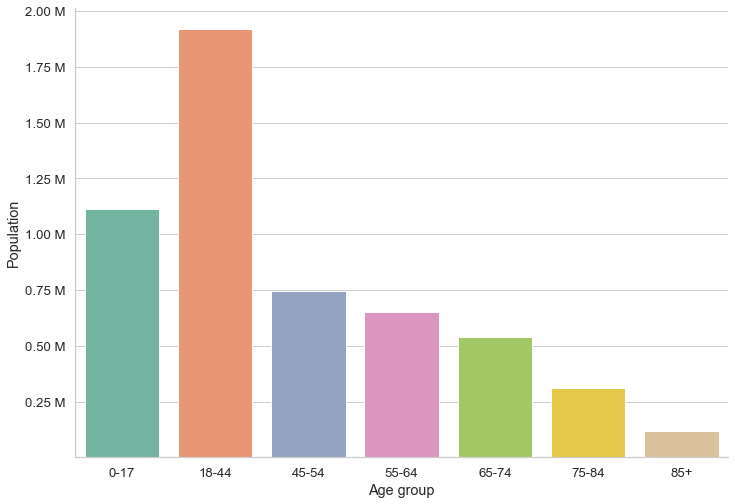

In [17]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
ax = sns.barplot(data=age_group_pop, x="Age group", y="Population", palette="Set2")
plt.xticks(rotation=0, horizontalalignment="center")
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, y: f"{x/1e6:.2f} M" if x > 0 else None))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig("plots/population.png", dpi=200)
plt.show()

In [ ]:
fhi_vaccine_plan = pd.read_csv("../data/fhi_vaccine_plan.csv")
fhi_vaccine_plan

In [36]:
df = pd.read_csv('data/deaths-us.csv')
df['age_0'] = df['Age Group'].apply(lambda x: int(str(x).split('-')[0]))
df['age_1'] = df['Age Group'].apply(lambda x: int(str(x).split('-')[1]))
df.drop(columns=['Age Group','Percent Cases', 'Percent Deaths'], inplace=True)

age = []
cases = []
deaths = []
for row in df.iterrows():
    info = row[1]
    interval = info.age_1 - info.age_0 + 1
    for i in range(info.age_0, info.age_1+1):
        age.append(i)
        cases.append(info.cases/interval)
        deaths.append(info.deaths/interval) 

df_new = pd.DataFrame(data={"age": np.array(age).T, "cases": np.array(cases).T.astype(int), "deaths": np.round(np.array(deaths).T,2)})
df_new.to_csv('data/deaths_by_age.csv', index=False)

In [4]:
df = pd.read_csv('data/response_measures/response_measures_data.csv', parse_dates=['date'])

In [5]:
df['cumulative_total_cases'] = 1e5 * df['cumulative_total_cases']/df['population']
df['active_cases'] = 1e5 * df['active_cases']/df['population']
df['cumulative_total_deaths'] = 1e5 * df['cumulative_total_deaths']/df['population']
df['daily_new_deaths'] = 1e5 * df['daily_new_deaths']/df['population']

In [6]:
infection_past_w = np.zeros(len(df))
infection_2w_ago = np.zeros(len(df))
deaths_past_w = np.zeros(len(df))
deaths_2w_ago = np.zeros(len(df))
for row in tqdm(df.iterrows()):
    info = row[1]
    today = info.date
    one_week_earlier = today - pd.Timedelta(1, unit="W")
    two_weeks_earlier = today - pd.Timedelta(2, unit="W")
    mask_1_week = (df.date > one_week_earlier) & (df.date <= today) & (df.country == info.country)
    mask_2_weeks_ago = (df.date > two_weeks_earlier) & (df.date <= one_week_earlier) & (df.country == info.country)
    infection_past_w[row[0]] = df[mask_1_week].daily_new_cases.sum()
    infection_2w_ago[row[0]] = df[mask_2_weeks_ago].daily_new_cases.sum()
    deaths_past_w[row[0]] = df[mask_1_week].daily_new_deaths.sum()
    deaths_2w_ago[row[0]] = df[mask_2_weeks_ago].daily_new_deaths.sum()

106712it [31:44, 56.03it/s]


In [7]:
df['cases_past_week'] = infection_past_w.T
df['cases_2w_ago'] = infection_2w_ago.T
df['deaths_past_week'] = deaths_past_w.T
df['deaths_2w_ago'] = deaths_2w_ago.T

In [170]:
df_R = df.set_index(['country','date'])
df_R = df_R[~df_R.index.duplicated(keep='first')]

In [239]:
r_numbers = pd.DataFrame(columns=["date", "country", "R_mean"])
for country, temp_df in tqdm(df_R.groupby(level=0)):
    cases = temp_df['daily_new_cases'].reset_index(level=0, drop=True).sort_index().abs()
    try:
        R_t = covid19.r_covid(cases, n_samples=10, r_window_size=3, smoothing_window=21)
    except:
        continue
    r_numbers = r_numbers.append(temp_df.reset_index().merge(R_t.reset_index(), left_on="date", right_on="index", how="left")[['date', 'country', 'R_mean']], ignore_index=True)

100%|██████████| 219/219 [01:44<00:00,  2.09it/s]


In [263]:
df_new = df.merge(r_numbers, on=["country", "date"], how="left").dropna()

In [265]:
df_new['cases_past_week'] = 1e5 * df['cases_past_week']/df['population']
df_new['cases_2w_ago'] = 1e5 * df['cases_2w_ago']/df['population']
df_new.drop(columns=["log_type", "daily_new_cases"], inplace=True)

In [267]:
df_new.to_csv("data/response_measures/training_data_response_measures.csv", index=False)

In [268]:
df_new

,country,date,cumulative_total_cases,active_cases,cumulative_total_deaths,daily_new_deaths,population,cases_past_week,cases_2w_ago,deaths_past_week,deaths_2w_ago,R_mean
29,Afghanistan,2020-03-07,0.010275,0.010275,0.000000,0.000000,38928346,0.007706,0.015413,0.000000,0.015413,2.862191
30,Afghanistan,2020-03-08,0.010275,0.010275,0.000000,0.000000,38928346,0.007706,0.012844,0.000000,0.012844,2.501294
31,Afghanistan,2020-03-09,0.010275,0.010275,0.000000,0.000000,38928346,0.007706,0.000000,0.000000,0.000000,2.110488
32,Afghanistan,2020-03-10,0.012844,0.012844,0.000000,0.000000,38928346,0.010275,0.000000,0.000000,0.000000,1.806786
33,Afghanistan,2020-03-11,0.017982,0.017982,0.000000,0.000000,38928346,0.015413,0.000000,0.000000,0.000000,1.643046
...,...,...,...,...,...,...,...,...,...,...,...,...
106697,Zimbabwe,2021-04-10,250.778380,5.873676,10.347897,0.020184,14862924,2.435591,0.625718,0.094194,0.033641,1.358949
106698,Zimbabwe,2021-04-11,250.879302,5.900589,10.347897,0.000000,14862924,2.455775,0.679543,0.087466,0.033641,1.238304
106699,Zimbabwe,2021-04-12,251.007137,5.813123,10.374809,0.026913,14862924,2.509600,0.639174,0.114379,0.033641,1.106196
106700,Zimbabwe,2021-04-13,251.161884,5.752569,10.381537,0.006728,14862924,2.449047,0.854475,0.080738,0.074010,0.977393


In [56]:
features = ['date', 'country', 'active_cases', 'cumulative_total_cases', 
            'cases_past_week', 'cases_2w_ago', 'cumulative_total_deaths',
            'deaths_past_week', 'deaths_2w_ago', 'response_measures', 'daily_new_cases']
df_model = df[features]
df_model.to_csv('data/training_data_response_measures.csv', index=False)

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from imblearn.over_sampling import SMOTE

df_model = pd.read_csv('data/training_data_response_measures.csv')
df_model = df_model[df_model.response_measures != 1]
 
rs = 10
y = df_model['response_measures'].values
X = df_model.drop(['response_measures'], axis=1).values

smote = SMOTE()
X, y = smote.fit_resample(X, y)

# fit and apply the transform
scaler = StandardScaler()
X = scaler.fit_transform(X, y)

model = MLPRegressor(random_state=rs)
model.fit(X, y)

MLPRegressor(random_state=10)

In [71]:
import pickle as pkl
pkl.dump(model, open('models/response_measure_model.sav', 'wb'))
pkl.dump(scaler, open('models/response_measure_scaler.sav', 'wb'))

In [47]:
pd.DataFrame(model.predict(X).T).describe()

,0
count,34330.000000
mean,0.979961
std,0.388573
min,-1.333067
25%,0.670214
50%,1.001488
75%,1.269324
max,2.336119


### Logistic regression

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('data/training_data_response_measures.csv')
df.response_measures = df.response_measures.apply(lambda x: x + 1 if x == 2 else x)

# set the random seed - consistent
rs = 10

# train test split
y = df['response_measures']
X = df.drop(['response_measures'], axis=1)
X_mat = X.values
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.2, stratify=y, random_state=rs)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
X_test = scaler.transform(X_test)

In [47]:
reg_model = LinearRegression()

# fit it to training data
reg_model.fit(X_train, y_train)

LinearRegression()

In [48]:
pd.Series(reg_model.predict(X_test).T).describe()

count    21343.000000
mean         0.911632
std          0.034033
min          0.522015
25%          0.897568
50%          0.898846
75%          0.908245
max          1.235894
dtype: float64

In [44]:
# training and test accuracy
print("Train accuracy:", reg_model.score(X_train, y_train))
print("Test accuracy:", reg_model.score(X_test, y_test))

# classification report on test data
y_pred = reg_model.predict(X_test)
print(classification_report(y_test, y_pred))

Train accuracy: 0.8058545842167532
Test accuracy: 0.8055100032797639
              precision    recall  f1-score   support

         0.0       0.57      0.03      0.05      3433
         1.0       0.81      1.00      0.89     17149
         3.0       0.60      0.00      0.01       761

    accuracy                           0.81     21343
   macro avg       0.66      0.34      0.32     21343
weighted avg       0.76      0.81      0.73     21343



In [7]:
# grab feature importances from the model and feature name from the original X
coef = reg_model.coef_[0]
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)

# limit to 20 features, you can leave this out to print out everything
indices = indices[:20]

for i in indices:
    print(feature_names[i], ':', coef[i])

cumulative_total_cases : -0.9305556889034542
deaths_2w_ago : -0.27900508159124604
deaths_past_week : -0.273883932985458
cases_past_week : 0.16812291647123256
cases_2w_ago : 0.15586800328792755
cumulative_total_deaths : 0.15464343350569612
cases_slope : 0.06470988289493548
active_cases : 0.023202408254912137
deaths_slope : 0.02139090320311021


### Log-transform

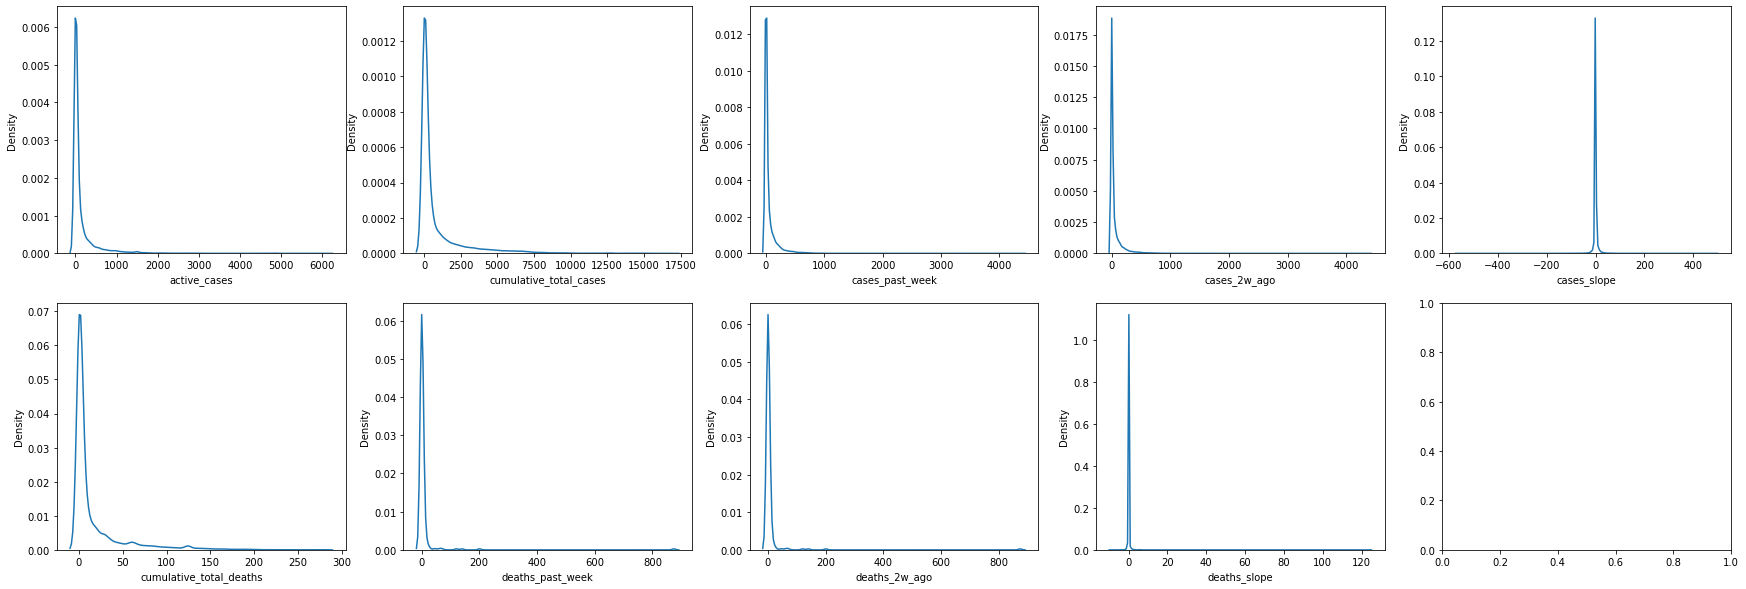

In [13]:
def plot_skewed_columns(df):
    # setting up subplots for easier visualisation
    f, axes = plt.subplots(2,5, figsize=(30,10), sharex=False)
    cols = ['active_cases', 'cumulative_total_cases', 'cases_past_week', 
            'cases_2w_ago', 'cases_slope', 'cumulative_total_deaths',
            'deaths_past_week', 'deaths_2w_ago', 'deaths_slope']

    for i, col in enumerate(cols):
        sns.distplot(df[col].dropna(), hist=False, ax=axes[i//5,i%5])

    plt.show()
    
plot_skewed_columns(df)

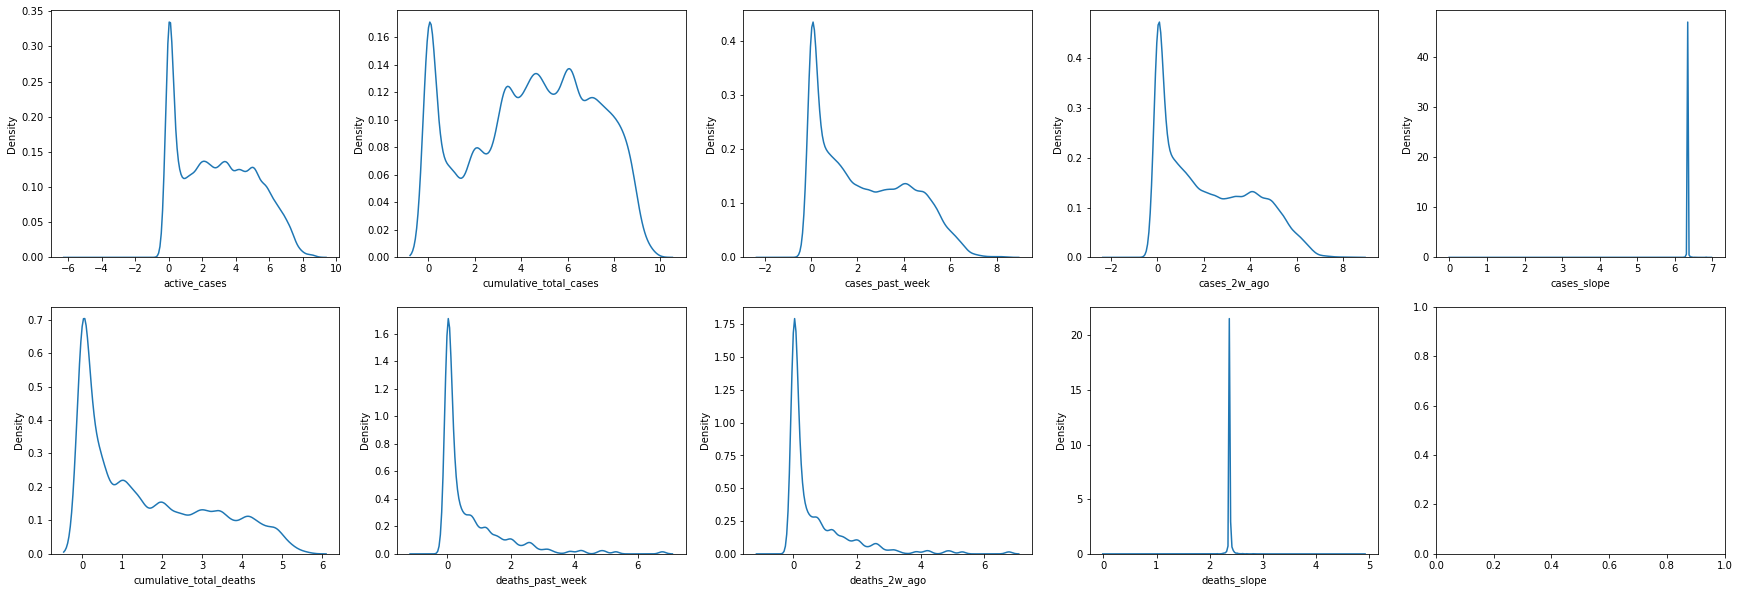

In [26]:
cols_to_transform = ['active_cases', 'cumulative_total_cases', 'cases_past_week', 
                    'cases_2w_ago', 'cases_slope', 'cumulative_total_deaths',
                    'deaths_past_week', 'deaths_2w_ago', 'deaths_slope']
# copy the dataframe
df_log = df.copy()
df_log['cases_slope'] = df_log['cases_slope'] + abs(df_log['cases_slope'].min())
df_log['deaths_slope'] = df_log['deaths_slope'] + abs(df_log['deaths_slope'].min())

# transform the columns with np.log
for col in cols_to_transform:
    df_log[col] = df_log[col].apply(lambda x: x+1)
    df_log[col] = df_log[col].apply(np.log)

df_log.dropna(inplace=True)
# plot them again to show the distribution
plot_skewed_columns(df_log)

In [27]:
# create X, y and train test data partitions
y_log = df_log['response_measures']
X_log = df_log.drop(['response_measures'], axis=1)
X_mat_log = X_log.values
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_mat_log, y_log, test_size=0.2, stratify=y_log, random_state=rs)

# standardise them again
scaler_log = StandardScaler()
X_train_log = scaler_log.fit_transform(X_train_log, y_train_log)
X_test_log = scaler_log.transform(X_test_log)

In [28]:
logreg_model = LogisticRegression(random_state=rs, max_iter=1000)

# fit it to training data
logreg_model.fit(X_train_log, y_train_log)

LogisticRegression(max_iter=1000, random_state=10)

In [29]:
# test the best model
print("Train accuracy:", logreg_model.score(X_train_log, y_train_log))
print("Test accuracy:", logreg_model.score(X_test_log, y_test_log))

y_pred_log = logreg_model.predict(X_test_log)
print(classification_report(y_test_log, y_pred_log))

Train accuracy: 0.8050670605890077
Test accuracy: 0.8043610785463071
              precision    recall  f1-score   support

         0.0       0.51      0.04      0.08      3430
         1.0       0.81      0.99      0.89     17135
         2.0       0.44      0.01      0.02       760

    accuracy                           0.80     21325
   macro avg       0.59      0.35      0.33     21325
weighted avg       0.75      0.80      0.73     21325



In [4]:
df = pd.read_csv('data/norway_commuters_2017_b2020.csv')
df

,Unnamed: 0,from,to,n
0,1,municip0301,municip1101,71.0
1,2,municip0301,municip1103,1423.0
2,3,municip0301,municip1106,332.0
3,4,municip0301,municip1108,652.0
4,5,municip0301,municip1111,5.0
...,...,...,...,...
23947,23948,municip5444,municip5439,3.0
23948,23949,municip5444,municip5440,1.0
23949,23950,municip5444,municip5441,33.0
23950,23951,municip5444,municip5442,12.0


In [6]:
df.drop(df.columns[0], axis=1, inplace=True)
df.rename({"from": "to", "to": "from"}, axis=1, inplace=True)
df = df[['from', 'to', 'n']]

In [9]:
df.sort_values('from').to_csv('data/norway_commuters_2017_b2020.csv', index=False)

In [30]:
df = pd.read_csv("data/age_groups/deaths_by_age.csv")
df['age_group'] = pd.cut(df['age'], bins=bins+[110], labels=labels, include_lowest=True)
df.groupby('age_group').mean()['ifr'].to_numpy()/100

array([1.89411765e-05, 3.42444444e-04, 2.25520000e-03, 7.54540000e-03,
       2.52441000e-02, 8.44572000e-02, 3.21552500e-01])